In [236]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm

In [ ]:
!pip install kaggle
from google.colab import files
files.upload() #API token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c ''
!kaggle datasets download 'tongpython/cat-and-dog'

In [ ]:
!unzip 'cat-and-dog.zip'

In [197]:
class Dataset2class(torch.utils.data.Dataset):
  def __init__(self, path1:str, path2:str):
    super().__init__()
    self.path1 = path1
    self.path2 = path2

    self.list1 = self.clean_listdir(sorted(os.listdir(path1)))
    self.list2 = self.clean_listdir(sorted(os.listdir(path2)))
    print(f'class 0: {len(self.list1)}')
    print(f'class 1: {len(self.list2)}')

  def __len__(self):
    return len(self.list1) + len(self.list2)

  def __getitem__(self, idx):
    if idx < len(self.list1):
      class_id = 0
      img_path = os.path.join(self.path1, self.list1[idx])
    else:
      class_id = 1
      img_path = os.path.join(self.path2, self.list2[idx-len(self.list1)])
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    img = img/255.0
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    img = img.transpose([2, 0, 1]) # HWC -> CHW
    t_img = torch.from_numpy(img)
    t_class_id = torch.tensor(class_id)
    return {'img': t_img, 'label': t_class_id}

  def clean_listdir(self, arr):
    new_arr = []
    for i in range(len(arr)):
      if arr[i][-3:] == 'jpg':
        new_arr.append(arr[i])
    return new_arr

In [198]:
def randomshow(data, random):
  for i in list(np.random.randint(0, len(data), random)):
      sample = train_data[i]
      img = sample['img'].numpy().transpose([1, 2, 0])
      label = sample['label'].numpy()
      print(f'class: {label}')
      plt.figure(figsize=(3, 3))
      plt.imshow(img)
      plt.show()

In [199]:
train_dogs_path = '/content/training_set/training_set/dogs'
train_cats_path = '/content/training_set/training_set/cats'
train_data = Dataset2class(train_dogs_path, train_cats_path)

test_dogs_path = '/content/test_set/test_set/dogs'
test_cats_path = '/content/test_set/test_set/cats'
test_data = Dataset2class(test_dogs_path, test_cats_path)

class 0: 4005
class 1: 4000
class 0: 1012
class 1: 1011


<class 'torch.Tensor'>
class: 0


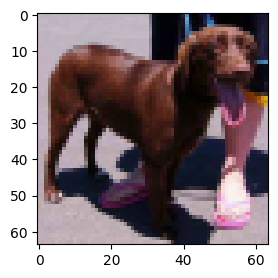

In [196]:
randomshow(train_data, 1)

In [200]:
BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_data, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=1, drop_last=False)

In [203]:
for i in train_loader:
  print(i['img'].shape)
  break

torch.Size([16, 3, 64, 64])


In [241]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.act = nn.LeakyReLU()
    self.maxpool = nn.MaxPool2d(2, 2)
    # in_channels, out_channels, kernel_size
    self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
    self.conv1 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
    self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128, 30)
    self.linear2 = nn.Linear(30, 2)

  def forward(self, x):
    out = self.conv0(x)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv1(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv2(out)
    out = self.act(out)
    out = self.maxpool(out)

    out = self.conv3(out)
    out = self.act(out)

    out = self.adaptivepool(out)
    out = self.flatten(out)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)
    return out

In [242]:
model = ConvNet()

In [243]:
def count_params(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_params(model)

244764

In [244]:
for i in train_loader:
  n = model(i['img'])
  print(n.shape)
  break

torch.Size([16, 2])


In [245]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [246]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [248]:
# device = 'cuda' if torch.cuda.is_available else 'cpu'
epochs = 10

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        optimizer.zero_grad()

        pred = model(img)
        loss = loss_function(pred, label)

        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item

        optimizer.step()

        acc_current = accuracy(pred, label)
        acc_val += acc_current

    pbar.set_description(f'loss: {loss_item:.5f}\taccuracy: {acc_current:.3f}')
    print(loss_val/len(train_loader))
    print(acc_val/len(train_loader))

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-246-50518e42ab3c>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 500/500 [01:27<00:00,  5.70it/s]


0.6735498099327087
0.58425


100%|██████████| 500/500 [01:25<00:00,  5.86it/s]


0.6466592759490013
0.63625


100%|██████████| 500/500 [01:25<00:00,  5.81it/s]


0.6059734188318252
0.6795


100%|██████████| 500/500 [01:29<00:00,  5.58it/s]


0.5406614051163197
0.724


100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


0.4909146178662777
0.7625


100%|██████████| 500/500 [01:29<00:00,  5.61it/s]


0.4500620909631252
0.79


100%|██████████| 500/500 [01:30<00:00,  5.55it/s]


0.4129757167994976
0.815625


100%|██████████| 500/500 [01:28<00:00,  5.67it/s]


0.37299123306572435
0.838625


100%|██████████| 500/500 [01:28<00:00,  5.67it/s]


0.33007449164241554
0.857


100%|██████████| 500/500 [01:27<00:00,  5.69it/s]

0.2914638843014836
0.879875


In [279]:
def dog_or_cat(model, path):
  img = cv2.imread(path, cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  img = img.astype(np.float32)
  img = img/255.0
  img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
  img = img.transpose([2, 0, 1]) # HWC -> CHW
  t_img = torch.from_numpy(img)
  return 'Гав!' if model(t_img[None, :, : :]).argmax().item() == 0 else  'Мяу'

'Мяу'

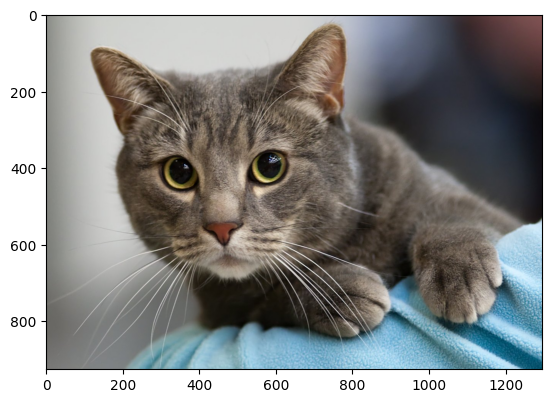

In [280]:
dog_or_cat(model, '/content/caaaat.jpg')

'Гав!'

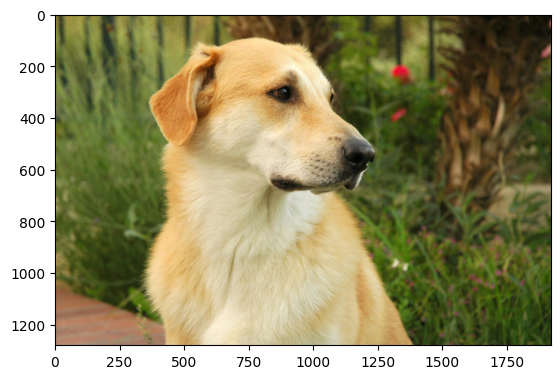

In [281]:
dog_or_cat(model, '/content/doooog.jpg')